In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import random
from utils import get_reward_model, get_score, get_scores_df, get_percent_chosen
from nltk.corpus import wordnet as wn
# from textblob import TextBlob
import matplotlib.pyplot as plt

In [4]:
np.random.seed(0)
random.seed(0)

In [109]:
original = pd.read_csv('data/openai_summarize_from_feedback/english_original.csv').sample(1000).reset_index(drop=True)
original = original.fillna('')
original

,prompt,chosen,rejected
0,"I'm a genuinely nice, considerate, and polite ...",I like girls with the opposite personality to ...,I'm kind of into these girls but they act like...
1,I've just come out of a 4 year relationships a...,Had 2 dates with a girl and now not sure if sh...,"Met a girl first date with her, she seemed uns..."
2,I'm 28m and she's 22F. We have been married fo...,I finger her and eat her out. She gets pissed ...,great day with so. She came 3 or 4 times. She ...
3,I've (25/F) been with my partner (32/M) for ma...,Long term partner started telling me about cro...,partner of ~2 years revealed kinks about cross...
4,"I've got two problems at the moment, both inte...",You're a badass Sysadmin. How do I get you int...,I'm looking for an IT pros that doesn't just r...
...,...,...,...
995,We started our friends with benefits a few mon...,I'm going to university and we're not sure if ...,My fwb and I really enjoy each other's company...
996,"Hey guys! I'm 21 (as is my fiance),and we've b...","Been with fiance for 2 years, engagement will ...","We're engaged for a year, and we're not religi..."
997,This week was declared a casual week at work. ...,Jokingly said I'd wear a dress to work and hav...,Coworker wearing a dress to work for charity. ...
998,So I was hooking up with this girl the other n...,"I think I have a hemorrhoid, how did I get it ...","I think I have a hemorrhoid, how do I get rid ..."


## Random Word Perturbation

In [16]:
from urllib.request import urlopen

word_site = "https://www-personal.umich.edu/~jlawler/wordlist"

response = urlopen(word_site)
txt = response.read().decode()
WORDS = txt.splitlines()
def get_random_word():
    return random.choice(WORDS)

In [62]:
def insert_word(word_list, i):
    return word_list[:i] + [get_random_word()] + word_list[i:]

def delete_word(word_list, i):
    return word_list[:i] + word_list[i+1:]

def replace_word(word_list, i):
    return word_list[:i] + [get_random_word()] + word_list[i+1:]

def do_action_word(s, i):
    r = np.random.rand()
    if r <= 0.33:
        return ' '.join(w for w in insert_word(s.split(), i)), i + 1
    elif r <= 0.67:
        return ' '.join(w for w in delete_word(s.split(), i)), i
    else:
        return ' '.join(w for w in replace_word(s.split(), i)), i
    
def perturb_word_string(s, prob_perturb=0.1):
    for i in range(len(s.split())):
        r = np.random.rand()
        if r <= prob_perturb:
            s, i = do_action_word(s, i)
    return s

## Random Char Perturbation

In [54]:
chars = string.ascii_letters + '0123456789 \n'
def get_random_char():
    return random.choice(chars)

In [55]:
def insert(s, i):
    return s[:i] + get_random_char() + s[i:]

def delete(s, i):
    return s[:i] + s[i+1:]

def replace(s, i):
    return s[:i] + get_random_char() + s[i+1:]

In [56]:
def do_action(s, i):
    r = np.random.rand()
    if r <= 0.33:
        return insert(s, i), i+ 1
    elif r <= 0.67:
        return delete(s,i), i
    else:
        return replace(s,i), i

In [57]:
def perturb_string(s, prob_perturb=0.1):
    for i in range(len(s)):
        r = np.random.rand()
        if r <= prob_perturb:
            s, i = do_action(s, i)
    return s

In [71]:
def perturb_df(df, prob_perturb):
    for i, row in original.iterrows():
#         df.prompt.iloc[i] = perturb_string(row.prompt, prob_perturb=prob_perturb)
        df.prompt.iloc[i] = perturb_word_string(row.prompt, prob_perturb=prob_perturb)
#         df.iloc[i].chosen = perturb_string(row.chosen, prob_perturb=prob_perturb)
        df.iloc[i].chosen = perturb_word_string(row.chosen, prob_perturb=prob_perturb)
#         df.iloc[i].rejected = perturb_string(row.rejected, prob_perturb=prob_perturb)
        df.iloc[i].rejected = perturb_word_string(row.rejected, prob_perturb=prob_perturb)
    return df

In [72]:
perturbed = {}
for prob_perturb in tqdm(np.arange(0, 1.0, 0.1)):
    perturbed[prob_perturb] = perturb_df(original.copy(), prob_perturb=prob_perturb)

100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


In [73]:
rank_model, tokenizer = get_reward_model()

In [74]:
perturbed_scores = {}
scores = {}
for prob_perturb, df_ in perturbed.items():
    scores[prob_perturb] = get_scores_df(df_, tokenizer=tokenizer, rank_model=rank_model)
perturbed_scores['prompt_and_response'] = scores

100%|███████████████████████████████████████| 1000/1000 [32:36<00:00,  1.96s/it]


In [75]:
scores = {}
for prob_perturb, df_ in perturbed.items():
    df_ = df_.copy()
    df_['prompt'] = original['prompt']
    scores[prob_perturb] = get_scores_df(df_, tokenizer=tokenizer, rank_model=rank_model)
perturbed_scores['response'] = scores

100%|███████████████████████████████████████| 1000/1000 [19:07<00:00,  1.15s/it]


In [82]:
scores = {}
for prob_perturb, df_ in perturbed.items():
    df_ = df_.copy()
    df_['chosen'] = original['chosen']
    df_['rejected'] = original['rejected']
    scores[prob_perturb] = get_scores_df(df_, tokenizer=tokenizer, rank_model=rank_model)
perturbed_scores['prompt'] = scores

100%|███████████████████████████████████████| 1000/1000 [27:11<00:00,  1.63s/it]


In [83]:
probs_both, accs_both = [], []
for k,v in perturbed_scores['prompt_and_response'].items():
    probs_both.append(k)
    accs_both.append(get_percent_chosen(v))
probs_prompt, accs_prompt = [], []
for k,v in perturbed_scores['prompt'].items():
    probs_prompt.append(k)
    accs_prompt.append(get_percent_chosen(v))
probs_response, accs_response = [], []
for k,v in perturbed_scores['response'].items():
    probs_response.append(k)
    accs_response.append(get_percent_chosen(v))

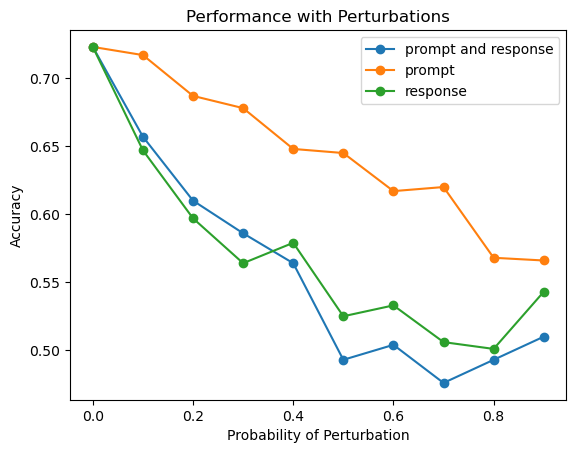

In [84]:
plt.plot(probs_both,accs_both, marker='o', label='prompt and response')
plt.plot(probs_prompt,accs_prompt, marker='o', label='prompt')
plt.plot(probs_response,accs_response, marker='o', label='response')
#plt.ylim(0.4, 0.8)
plt.xlabel('Probability of Perturbation')
plt.ylabel('Accuracy')
plt.title('Performance with Perturbations')
plt.legend()

In [97]:
for perturb_partition in perturbed_scores:
    for perturb_percent in perturbed_scores[perturb_partition]:
        percent = str(perturb_percent).replace('.','')
        try:
            os.mkdir(f'model_scores/deberta_v3_large/{perturb_partition}/{percent}')
        except:
            pass
        pd.DataFrame(perturbed_scores[perturb_partition][perturb_percent]).to_csv(f'model_scores/deberta_v3_large/open_ai_summarize_from_feedback/{perturb_partition}/{percent}_scores.csv', index=False)

In [89]:
pd.DataFrame(perturbed_scores['prompt_and_response'][0.0]).to_csv('model_scores/deberta_v3_large/prompt_and_response_perturbed_00.csv', index=False)

Replace nouns

In [ ]:
all_nouns = [word.replace('_', ' ') for synset in wn.all_synsets(wn.NOUN) for word in synset.lemma_names()]